# Bernoulli-Beta Conjugate by MCMC

- We try to produce Figure 6.4 in page 135 of DBDA 2nd.
- Figure 6.4 is obtained by mathematical analysis.
- Here we produce it with MCMC. It should be almost the same. 'Almost' because of sampling approximation.

In [3]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [4]:
rng_key = random.PRNGKey(0)

## With Binomial Likelihood

In [24]:
def model_Binomial(a, b, N, z=17):
    th = numpyro.sample('theta', dist.Beta(a, b))
    obs = numpyro.sample('obs', dist.Binomial(total_count=N, probs=th), obs=z)

In [25]:
numpyro.render_model(model_Binomial, model_args=(100,100,20,17))

AttributeError: module 'numpyro' has no attribute 'render_model'

## Run MCMC inference

In [26]:
kernel = NUTS(model_Binomial)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)

#
a,b = 100, 100  # prior model (10, 10), (1,1)
N, z = 20, 17   # observation from binomial (200, 170) (2000, 1700)
#
mcmc.run(rng_key, a=b, b=b, N=N, z=z)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:06<00:00, 946.68it/s, 1 steps of size 1.19e+00. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.53      0.03      0.53      0.48      0.59   1714.80      1.00

Number of divergences: 0


In [27]:
samples_binom = mcmc.get_samples()
samples = samples_binom
samples

{'theta': DeviceArray([0.50705713, 0.50041777, 0.47321218, ..., 0.56185734,
              0.59933823, 0.59171224], dtype=float32)}

In [28]:
samples['theta'].shape

(5000,)

In [29]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

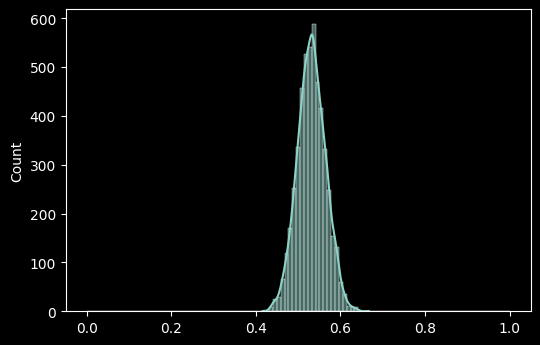

In [30]:
x = np.linspace(0, 1, 110)
sns.histplot(samples['theta'], kde=True, bins=x, );

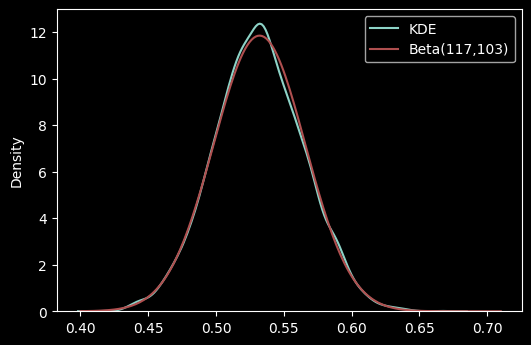

In [31]:
x = np.linspace(.4, .71, 200)
apost, bpost = a+z, b+N-z
pdf = stats.beta.pdf(x, a=apost, b=bpost) # PDF of Beta

ax = sns.kdeplot(samples['theta'])        # KDE of samples
# ax.set(label='KDE')
ax.plot(x, pdf, '-', c='#af4f4f')
ax.legend(['KDE', f'Beta({apost},{bpost})']);

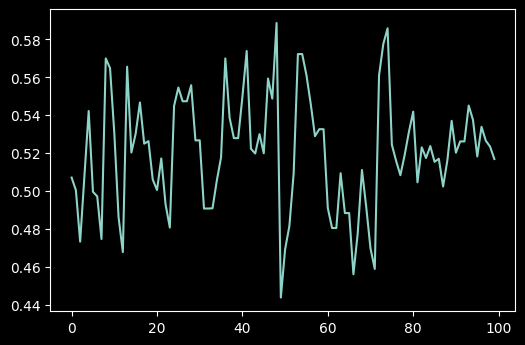

In [32]:
th = samples['theta']
plt.plot(th[:100])

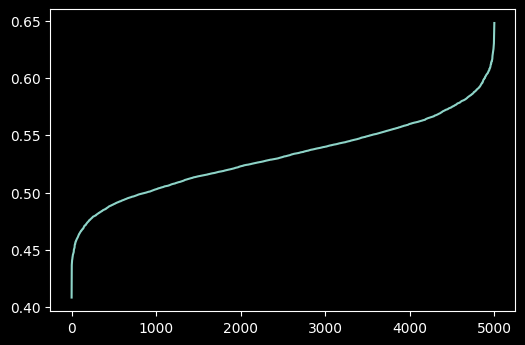

In [28]:
# median
sth = np.sort(th)
plt.plot(sth)

In [29]:
sth[5000//2]

0.5311906

In [9]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
hdi = (s[low_index].item(), s[high_index].item())
print(f'hdi: [{hdi[0]:.3f}, {hdi[1]:.3f}]')

hdi: [0.471, 0.595]


Mode of Beta(a,b):

$$
    mode = \frac{a-1}{a+b-2} \quad\mbox{for}\quad a,b > 1
$$

In [10]:
# Mode/Peak of the density approximation
import scipy 
kde = scipy.stats.gaussian_kde(s)  # density function approximation
x = np.linspace(0, 1, 1200)
pdfx = kde.evaluate(x) # function values at x
max_index = pdfx.argmax()
print(f'The KDE mode is at     {x[max_index]:.3f}')

mode = (apost - 1) / (apost + bpost - 2)
print(f'Theoretical mode is at {mode}')

The KDE mode is at     0.527
Theoretical mode is at 0.5321100917431193


hdi:  (0.4707302153110504, 0.5951700210571289)


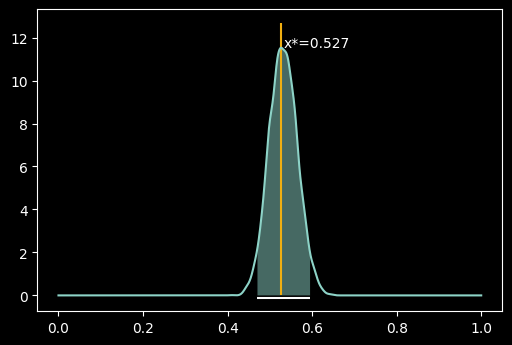

In [11]:
plt.plot(x, pdfx);
plt.vlines(x=x[max_index], ymin=0, ymax=pdfx[max_index]*1.1, colors='#f1af11');
plt.text(x=x[max_index]*1.01, y=pdfx[max_index], s=f'x*={x[max_index]:.3}');
#
plt.hlines(y=-.1, xmin=s[low_index], xmax=s[high_index])
pdfs = kde.evaluate(s)
plt.fill_between(s[low_index:high_index+1], pdfs[low_index:high_index+1], alpha=.5);
#
print('hdi: ', hdi)

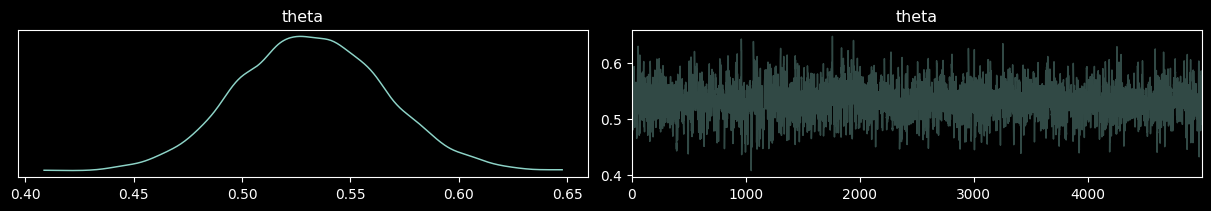

In [12]:
import arviz
arviz.plot_trace(samples);

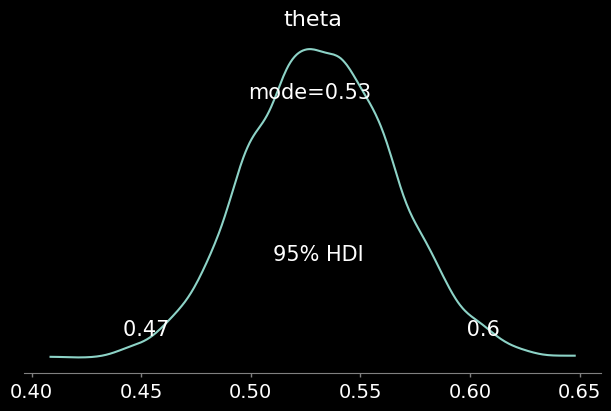

In [13]:
arviz.plot_posterior(samples, point_estimate='mode', bins=x, hdi_prob=.95);

In [9]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

## With Bernoulli Likelihood

In [10]:
def model_Bernoulli(a, b, y=None):
    theta = numpyro.sample('theta', dist.Beta(a, b))
    with numpyro.plate(f'N={len(y)}', size=len(y) if y is not None else 1):
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)
#

In [11]:
# generate an observation (z=17, N=20)
y = jnp.array([1.]*17 + [0.]*3)
print('y:', y)

y: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


In [12]:
numpyro.render_model(model_Bernoulli, model_args=(a, b, y))

AttributeError: module 'numpyro' has no attribute 'render_model'

In [35]:
kernel = NUTS(model_Bernoulli)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=18000, num_chains=1)
mcmc.run(rng_key, a=100, b=100, y=y)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 21000/21000 [00:18<00:00, 1127.26it/s, 3 steps of size 1.11e+00. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.53      0.03      0.53      0.48      0.59   6418.22      1.00

Number of divergences: 0


In [37]:
samples

{'theta': DeviceArray([0.50705713, 0.50041777, 0.47321218, ..., 0.56185734,
              0.59933823, 0.59171224], dtype=float32)}

In [38]:
print(samples['theta'])

[0.50705713 0.50041777 0.47321218 ... 0.56185734 0.59933823 0.59171224]


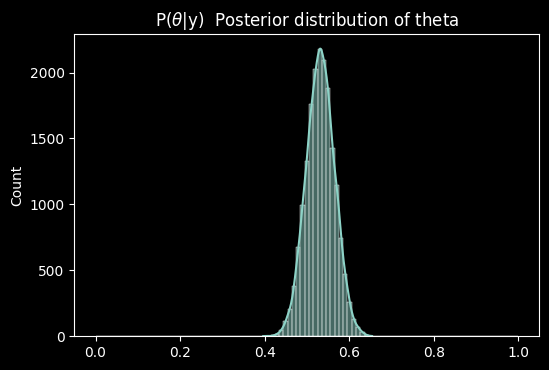

In [39]:
samples = mcmc.get_samples()
x = np.linspace(0, 1, 100)
ax = sns.histplot(samples['theta'], kde=True, bins=x);
ax.set(title='P($\\theta$|y)  Posterior distribution of theta');

In [40]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
print(f'hdi: [{s[low_index]:.3f}, {s[high_index]:.3f}]')

hdi: [0.469, 0.595]


In [41]:
import arviz

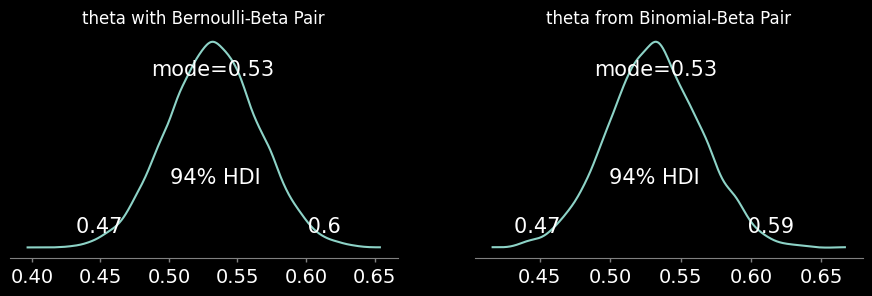

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 3))
arviz.plot_posterior(samples, ax=ax1, point_estimate='mode');
ax1.set(title='theta with Bernoulli-Beta Pair')
arviz.plot_posterior(samples_binom, ax=ax2, point_estimate='mode'); 
ax2.set(title='theta from Binomial-Beta Pair');

## Compare MCMC with the theoretical posterior

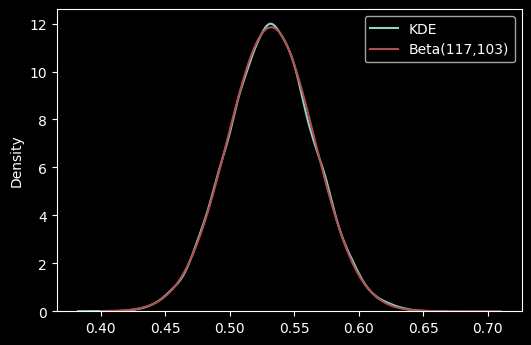

In [43]:
x = np.linspace(.4, .71, 200)
apost, bpost = a+z, b+N-z
pdf = stats.beta.pdf(x, a=apost, b=bpost) # PDF of Beta

ax = sns.kdeplot(samples['theta'])        # KDE of samples
# ax.set(label='KDE')
ax.plot(x, pdf, '-', c='#af4f4f')
ax.legend(['KDE', f'Beta({apost},{bpost})']);

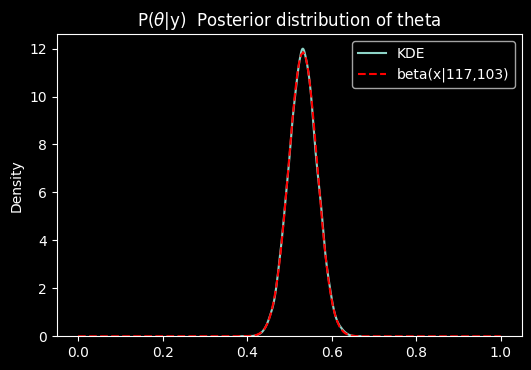

In [44]:
aa = 100 + 17
bb = 100 + 3
x = jnp.linspace(0,1,200)
pdf = jax.scipy.stats.beta.pdf(x, aa, bb)  # https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.stats.beta.pdf.html

# plot pdf, overlayed on the sample histogram chart.
samples = mcmc.get_samples()
ax = sns.kdeplot(samples['theta']);
ax.set(title='P($\\theta$|y)  Posterior distribution of theta');
ax.plot(x, pdf, 'r--');
ax.legend(['KDE', f'beta(x|{aa},{bb})']);

End.

In [23]:
!jupyter nbconvert Ch.6.Bernoulli_beta_numpyro.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Ch.6.Bernoulli_beta_numpyro.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 333453 bytes to Ch.6.Bernoulli_beta_numpyro.pdf
